# 导入相关软件包

In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import scipy.sparse as sp
from scipy.stats import entropy

In [2]:
# 随机种子
def seed_pytorch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# 参数配置

In [64]:
config_para = {
    'seed': 42,
    'base_dir': '../shared_datasets/bag+of+words',
    'k_values': [2, 5, 10, 20],
    'datasets': [
        {"name": "NIPS Papers", "docword": "docword.nips.txt", "vocab": "vocab.nips.txt"},
        {"name": "KOS Blogs", "docword": "docword.kos.txt", "vocab": "vocab.kos.txt"},
        {"name": "PUBMED", "docword": "docword.pubmed.txt", "vocab": "vocab.pubmed.txt"},
        {"name": "ENRON", "docword": "docword.enron.txt", "vocab": "vocab.enron.txt"},
        {"name": "NY Times", "docword": "docword.nytimes.txt", "vocab": "vocab.nytimes.txt"}
    ]
}

In [4]:
sns.set(style="whitegrid")

seed_pytorch(seed=config_para['seed'])

# 数据读入与预处理

In [5]:
# 加载文档-词频矩阵和词汇表
def load_data(docword_file, vocab_file):
    with open(docword_file, 'r') as f:
        lines = f.readlines()
    D, W, NNZ = map(int, lines[:3])
    data = np.array([list(map(int, line.strip().split())) for line in lines[3:]])
    
    doc_ids = data[:, 0] - 1
    word_ids = data[:, 1] - 1
    counts = data[:, 2]
    sparse_matrix = sp.coo_matrix((counts, (doc_ids, word_ids)), shape=(D, W))
    
    with open(vocab_file, 'r') as f:
        vocab = [line.strip() for line in f.readlines()]
    
    return sparse_matrix, vocab

# 计算TF-IDF特征
def compute_tfidf(sparse_matrix):
    transformer = TfidfTransformer()
    return transformer.fit_transform(sparse_matrix)

In [ ]:
# 获取数据集路径
dataset = config_para['datasets'][0]
docword_file = os.path.join(config_para['base_dir'], dataset["docword"])
vocab_file = os.path.join(config_para['base_dir'], dataset["vocab"])

In [7]:
# 加载数据
nips_matrix, nips_vocab = load_data(docword_file, vocab_file)

In [13]:
nips_matrix

<1500x12419 sparse matrix of type '<class 'numpy.int32'>'
	with 746316 stored elements in COOrdinate format>

In [20]:
# nips_matrix.shape[0] # 1500篇文章
nips_matrix.shape[1] # 12419个词

12419

In [19]:
100.0 * nips_matrix.nnz / (nips_matrix.shape[0] * nips_matrix.shape[1]) # 稀疏度

4.006312907641517

In [14]:
len(nips_vocab) # 词表大小，与上述相符

12419

# 特征提取

In [15]:
nips_tfidf = compute_tfidf(nips_matrix) # 计算TF-IDF特征

In [16]:
nips_tfidf.shape

(1500, 12419)

# 可视化和探索性数据分析

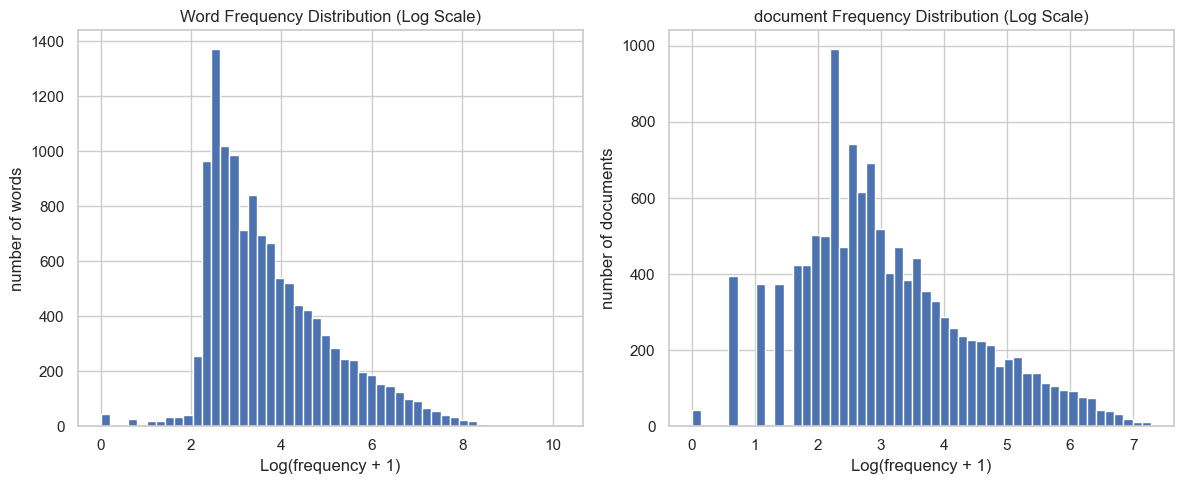

In [17]:
# 词频可视化

# 统计信息
term_freqs = np.asarray(nips_matrix.sum(axis=0))[0]
doc_freqs = np.asarray((nips_matrix > 0).sum(axis=0))[0]

# 可视化
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(np.log1p(term_freqs), bins=50)
plt.title('Word Frequency Distribution (Log Scale)')
plt.xlabel('Log(frequency + 1)')
plt.ylabel('number of words')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(doc_freqs), bins=50)
plt.title('document Frequency Distribution (Log Scale)')
plt.xlabel('Log(frequency + 1)')
plt.ylabel('number of documents')

plt.tight_layout()
plt.show()

In [22]:
# 对高频词做一个case study
top_n = 20
top_terms_idx = np.argsort(-term_freqs)[:top_n]

print(f"最常见的{top_n}个词：")
for idx in top_terms_idx:
    print(f"{nips_vocab[idx]}: {term_freqs[idx]}")

最常见的20个词：
network: 25977
model: 18665
learning: 16075
function: 14704
input: 13993
neural: 12667
set: 11677
algorithm: 11250
system: 11076
data: 11023
training: 9871
unit: 9612
output: 8914
weight: 8576
result: 8372
error: 8343
problem: 8225
number: 7614
neuron: 6849
method: 6532


# K-Means实现

In [36]:
class MyKMeans:
    def __init__(self, n_clusters=2, init_centroids=None, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.init_centroids = init_centroids
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
    
    def _compute_distances(self, X):
        """计算每个样本到各个质心的欧氏距离"""
        distances = np.zeros((X.shape[0], self.n_clusters))
        X_squared_sum = np.asarray(X.multiply(X).sum(axis=1)).ravel()
        
        for i in range(self.n_clusters):
            # 计算 ||x - c||^2 = ||x||^2 + ||c||^2 - 2x^T c
            centroid = self.centroids[i]
            centroid_squared_sum = np.sum(centroid ** 2)
            
            # 计算 -2x^T c
            prod = X.dot(centroid)
            
            # 组合所有项
            distances[:, i] = X_squared_sum + centroid_squared_sum - 2 * prod
            
        return np.sqrt(np.maximum(distances, 0))
    
    def fit(self, X):
        """训练模型"""
        X = sp.csr_matrix(X)  # 确保输入是CSR格式
        n_samples, n_features = X.shape
        
        if self.init_centroids is not None:
            self.centroids = self.init_centroids
        else:
            # 随机初始化聚类中心
            random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
            self.centroids = X[random_indices].toarray()
        
        for iteration in range(self.max_iter):
            # 计算距离并分配标签
            distances = self._compute_distances(X)
            new_labels = np.argmin(distances, axis=1)
            
            if iteration > 0 and np.all(new_labels == self.labels_):
                print(f"算法在第 {iteration + 1} 轮迭代后达到标签稳定")
                break
                
            self.labels_ = new_labels
            
            # 更新中心点
            new_centroids = np.zeros((self.n_clusters, n_features))
            for k in range(self.n_clusters):
                cluster_mask = self.labels_ == k
                if np.any(cluster_mask):
                    cluster_points = X[cluster_mask]
                    new_centroids[k] = np.asarray(cluster_points.mean(axis=0)).ravel()
            
            # 检查收敛性
            centroid_shift = np.max(np.linalg.norm(self.centroids - new_centroids, axis=1))
            self.centroids = new_centroids
            
            if centroid_shift <= self.tol:
                print(f"算法在第 {iteration + 1} 轮迭代后收敛")
                break
                
        if iteration == self.max_iter - 1:
            print(f"算法在达到最大迭代次数 {self.max_iter} 后停止")
        
        # 计算类内距离
        self.inertia_ = 0
        distances = self._compute_distances(X)
        for k in range(self.n_clusters):
            cluster_mask = self.labels_ == k
            if np.any(cluster_mask):
                self.inertia_ += np.sum(distances[cluster_mask, k] ** 2)
                
        return self

# 实验

In [37]:
# 对不同的k值进行实验
results = {}

for k in config_para['k_values']:
    print(f"\n{'='*20} k = {k} {'='*20}")
    
    # 执行聚类
    kmeans = MyKMeans(n_clusters=k, max_iter=300)
    kmeans.fit(nips_tfidf)
    
    # 计算评估指标
    silhouette_avg = silhouette_score(nips_tfidf, kmeans.labels_, sample_size=2000)
    
    # 输出结果
    print(f"\n评估指标:")
    print(f"- 轮廓系数: {silhouette_avg:.4f}")
    print(f"- 簇内平方和: {kmeans.inertia_:.4f}")
    
    # 分析簇的大小分布
    cluster_sizes = np.bincount(kmeans.labels_)
    print("\n簇的大小分布:")
    for i in range(k):
        size_percent = 100 * cluster_sizes[i] / len(kmeans.labels_)
        print(f"簇 {i}: {cluster_sizes[i]} 个文档 ({size_percent:.1f}%)")
    
    # 存储结果
    results[k] = {
        'labels': kmeans.labels_,
        'centroids': kmeans.centroids,
        'silhouette': silhouette_avg,
        'inertia': kmeans.inertia_,
        'sizes': cluster_sizes
    }


==================== k = 2 ====================
算法在第 12 轮迭代后达到标签稳定

评估指标:
- 轮廓系数: 0.0045
- 簇内平方和: 1396.3514

簇的大小分布:
簇 0: 1409 个文档 (93.9%)
簇 1: 91 个文档 (6.1%)

==================== k = 5 ====================
算法在第 21 轮迭代后达到标签稳定

评估指标:
- 轮廓系数: 0.0078
- 簇内平方和: 1362.5006

簇的大小分布:
簇 0: 426 个文档 (28.4%)
簇 1: 282 个文档 (18.8%)
簇 2: 158 个文档 (10.5%)
簇 3: 414 个文档 (27.6%)
簇 4: 220 个文档 (14.7%)

==================== k = 10 ====================
算法在第 21 轮迭代后达到标签稳定

评估指标:
- 轮廓系数: 0.0132
- 簇内平方和: 1328.8654

簇的大小分布:
簇 0: 207 个文档 (13.8%)
簇 1: 141 个文档 (9.4%)
簇 2: 276 个文档 (18.4%)
簇 3: 102 个文档 (6.8%)
簇 4: 350 个文档 (23.3%)
簇 5: 57 个文档 (3.8%)
簇 6: 82 个文档 (5.5%)
簇 7: 146 个文档 (9.7%)
簇 8: 39 个文档 (2.6%)
簇 9: 100 个文档 (6.7%)

==================== k = 20 ====================
算法在第 18 轮迭代后达到标签稳定

评估指标:
- 轮廓系数: 0.0125
- 簇内平方和: 1293.9079

簇的大小分布:
簇 0: 22 个文档 (1.5%)
簇 1: 12 个文档 (0.8%)
簇 2: 27 个文档 (1.8%)
簇 3: 26 个文档 (1.7%)
簇 4: 95 个文档 (6.3%)
簇 5: 156 个文档 (10.4%)
簇 6: 47 个文档 (3.1%)
簇 7: 19 个文档 (1.3%)
簇 8: 90 个文档 (6.0%)
簇 9: 24

# 相关评估

## 聚类性能评估

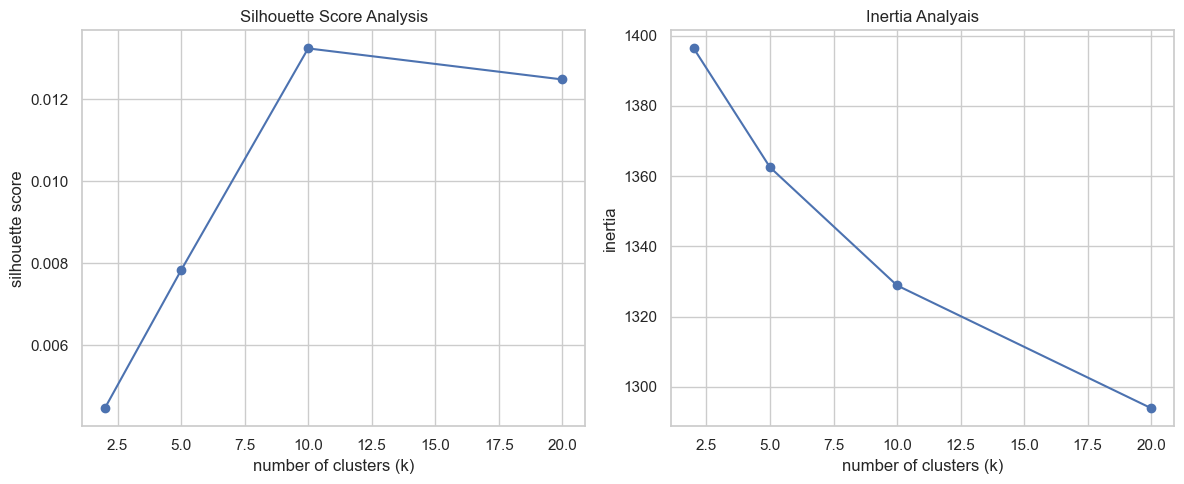

In [41]:
# 不同k值时的轮廓系数与簇内距离
k_values = sorted(results.keys())
silhouette_scores = [results[k]['silhouette'] for k in k_values]
inertia_scores = [results[k]['inertia'] for k in k_values]

plt.figure(figsize=(12, 5))

# 轮廓系数
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, 'o-')
plt.title('Silhouette Score Analysis')
plt.xlabel('number of clusters (k)')
plt.ylabel('silhouette score')

# 簇内距离
plt.subplot(1, 2, 2)
plt.plot(k_values, inertia_scores, 'o-')
plt.title('Inertia Analyais')
plt.xlabel('number of clusters (k)')
plt.ylabel('inertia')

plt.tight_layout()
plt.show()

## 簇内高频词case study与簇间相似性

In [42]:
## 找到最佳聚类结果

# 使用最佳k值的结果（10）
best_k = k_values[np.argmax(silhouette_scores)]
best_results = results[best_k]
best_labels = best_results['labels']

print(best_results)
print(best_labels)

{'labels': array([2, 2, 2, ..., 3, 3, 0], dtype=int64), 'centroids': array([[9.67916767e-04, 8.63599583e-04, 5.16344884e-04, ...,
        2.35234157e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.15506975e-03, ...,
        9.21494539e-05, 3.61183170e-04, 0.00000000e+00],
       [0.00000000e+00, 7.11445215e-04, 3.40654520e-04, ...,
        1.69773545e-04, 4.68650620e-04, 0.00000000e+00],
       ...,
       [0.00000000e+00, 7.12410271e-05, 0.00000000e+00, ...,
        5.48690180e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.28319458e-04, ...,
        0.00000000e+00, 5.40694890e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]), 'silhouette': 0.013235054512501674, 'inertia': 1328.8654149177216, 'sizes': array([207, 141, 276, 102, 350,  57,  82, 146,  39, 100], dtype=int64)}
[2 2 2 ... 3 3 0]


In [47]:
nips_matrix_csr = sp.csr_matrix(nips_matrix) # 防止报错

print(f"聚类结果深入分析 (k = {best_k})")

# 对每个簇进行分析
for cluster_id in range(best_k):
    # 获取该簇的文档
    cluster_mask = (best_labels == cluster_id)
    cluster_docs = nips_matrix_csr[cluster_mask]
    cluster_size = np.sum(cluster_mask)
    
    # 计算该簇的词频统计
    cluster_term_sums = np.asarray(cluster_docs.sum(axis=0)).ravel()
    cluster_term_freqs = cluster_term_sums / cluster_size  # 平均词频
    
    # 获取最具代表性的词（TF值最高的词）
    top_terms_idx = np.argsort(-cluster_term_freqs)[:10]
    
    print(f"\n簇 {cluster_id} 分析:")
    print(f"文档数量: {cluster_size} ({100 * cluster_size / len(best_labels):.1f}% 的文档)")
    print("代表性词汇 (按平均词频排序):")
    print("-" * 40)
    print(f"{'词汇':<20} {'平均词频':>10} {'文档覆盖率':>12}")
    print("-" * 40)
    
    for idx in top_terms_idx:
        # 计算该词在簇中的文档覆盖率
        term_docs = np.sum(cluster_docs[:, idx].toarray() > 0)
        coverage = 100 * term_docs / cluster_size
        print(f"{nips_vocab[idx]:<20} {cluster_term_freqs[idx]:>10.4f} {coverage:>11.1f}%")

聚类结果深入分析 (k = 10)

簇 0 分析:
文档数量: 207 (13.8% 的文档)
代表性词汇 (按平均词频排序):
----------------------------------------
词汇                         平均词频        文档覆盖率
----------------------------------------
algorithm               17.4251        83.6%
function                17.2222        94.2%
learning                17.1546        87.4%
network                 12.0145        84.5%
set                      9.0531        88.4%
error                    8.9710        74.4%
problem                  8.2029        87.9%
neural                   7.2415        85.5%
result                   7.1836        93.7%
weight                   7.1691        71.5%

簇 1 分析:
文档数量: 141 (9.4% 的文档)
代表性词汇 (按平均词频排序):
----------------------------------------
词汇                         平均词频        文档覆盖率
----------------------------------------
image                   16.8369        97.9%
model                   14.2908        87.9%
network                 14.0355        86.5%
object                  11.9645        75.2%
ima

In [49]:
print("簇间相似性分析")

similarities = []
for i in range(best_k):
    for j in range(i+1, best_k):
        # 计算两个簇的中心向量的余弦相似度
        centroid_i = results[best_k]['centroids'][i]
        centroid_j = results[best_k]['centroids'][j]
        similarity = np.dot(centroid_i, centroid_j) / (np.linalg.norm(centroid_i) * np.linalg.norm(centroid_j))
        similarities.append((i, j, similarity))

# 按相似度降序排序
similarities.sort(key=lambda x: x[2], reverse=True)

# 输出排序后的结果
for i, j, similarity in similarities:
    print(f"簇 {i} 和簇 {j} 的相似度: {similarity:.4f}")

簇间相似性分析
簇 0 和簇 4 的相似度: 0.7494
簇 0 和簇 2 的相似度: 0.7382
簇 2 和簇 4 的相似度: 0.7349
簇 5 和簇 8 的相似度: 0.6738
簇 1 和簇 4 的相似度: 0.6397
簇 7 和簇 9 的相似度: 0.6229
簇 1 和簇 2 的相似度: 0.5824
簇 2 和簇 6 的相似度: 0.5661
簇 4 和簇 6 的相似度: 0.5474
簇 0 和簇 3 的相似度: 0.5285
簇 0 和簇 1 的相似度: 0.5136
簇 3 和簇 4 的相似度: 0.4977
簇 1 和簇 7 的相似度: 0.4948
簇 4 和簇 7 的相似度: 0.4743
簇 2 和簇 7 的相似度: 0.4686
簇 2 和簇 9 的相似度: 0.4647
簇 2 和簇 3 的相似度: 0.4638
簇 2 和簇 5 的相似度: 0.4617
簇 1 和簇 6 的相似度: 0.4592
簇 4 和簇 9 的相似度: 0.4583
簇 5 和簇 9 的相似度: 0.4293
簇 0 和簇 6 的相似度: 0.4256
簇 8 和簇 9 的相似度: 0.4233
簇 5 和簇 7 的相似度: 0.4128
簇 1 和簇 5 的相似度: 0.4090
簇 4 和簇 5 的相似度: 0.4069
簇 0 和簇 9 的相似度: 0.4042
簇 0 和簇 5 的相似度: 0.3844
簇 7 和簇 8 的相似度: 0.3827
簇 2 和簇 8 的相似度: 0.3683
簇 1 和簇 9 的相似度: 0.3616
簇 0 和簇 7 的相似度: 0.3596
簇 1 和簇 3 的相似度: 0.3492
簇 0 和簇 8 的相似度: 0.3372
簇 4 和簇 8 的相似度: 0.3267
簇 5 和簇 6 的相似度: 0.3211
簇 6 和簇 7 的相似度: 0.3149
簇 6 和簇 9 的相似度: 0.3034
簇 3 和簇 7 的相似度: 0.2981
簇 1 和簇 8 的相似度: 0.2853
簇 3 和簇 9 的相似度: 0.2843
簇 3 和簇 6 的相似度: 0.2809
簇 3 和簇 5 的相似度: 0.2605
簇 6 和簇 8 的相似度: 0.2337
簇 3 和簇 8 的相似度: 0.2031


# 可视化

In [56]:
# 设置可视化样式
plt.style.use('default')
colors = plt.cm.tab20(np.linspace(0, 1, best_k))

# 降维以便可视化
pca = PCA(n_components=2)
tfidf_dense = nips_tfidf.toarray()
coords_2d = pca.fit_transform(tfidf_dense)

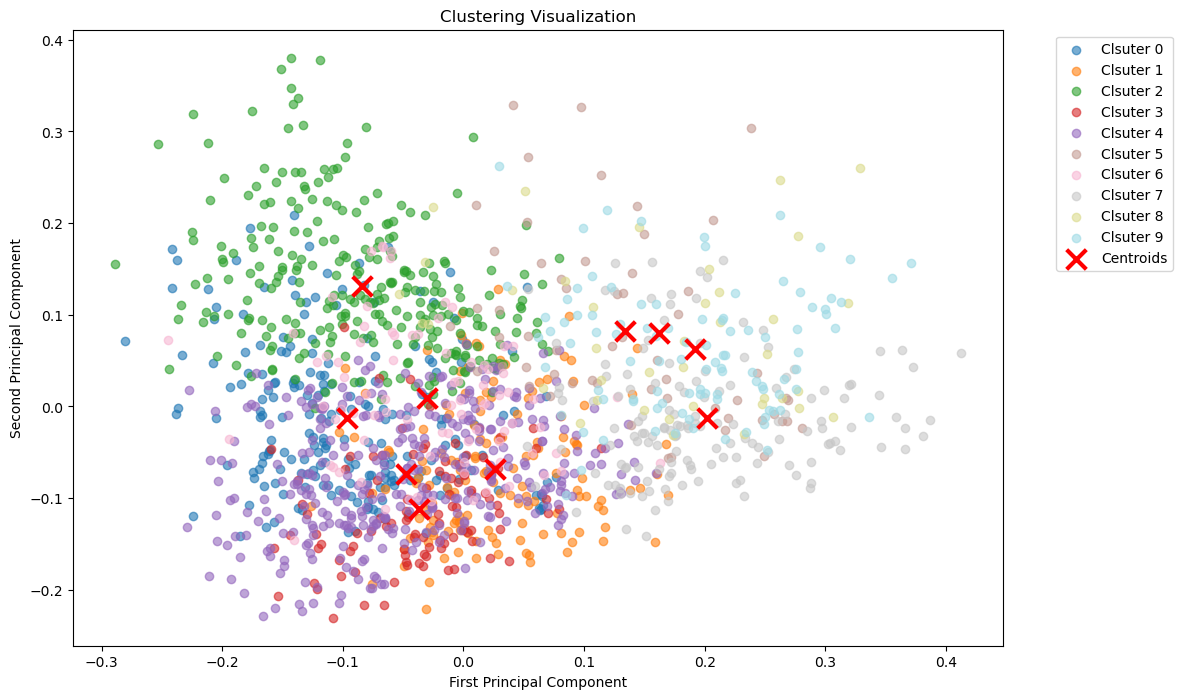

In [58]:
# 聚类结果散点图
plt.figure(figsize=(12, 8))
for i in range(best_k):
    mask = best_labels == i
    plt.scatter(coords_2d[mask, 0], coords_2d[mask, 1], 
                c=[colors[i]], label=f'Clsuter {i}', alpha=0.6)
plt.scatter(pca.transform(results[best_k]['centroids'])[:, 0],
            pca.transform(results[best_k]['centroids'])[:, 1],
            c='red', marker='x', s=200, linewidths=3, label='Centroids')
plt.title('Clustering Visualization')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

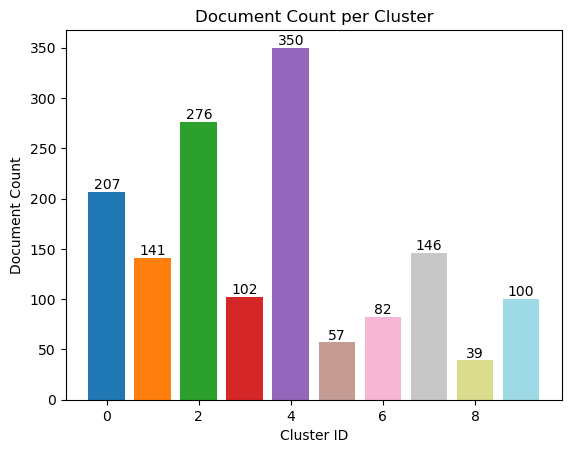

In [59]:
# 簇大小分布条形图
cluster_sizes = np.bincount(best_labels)
plt.bar(range(best_k), cluster_sizes, color=colors)
plt.title('Document Count per Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Document Count')
for i, size in enumerate(cluster_sizes):
    plt.text(i, size, str(size), ha='center', va='bottom')
    
plt.show()

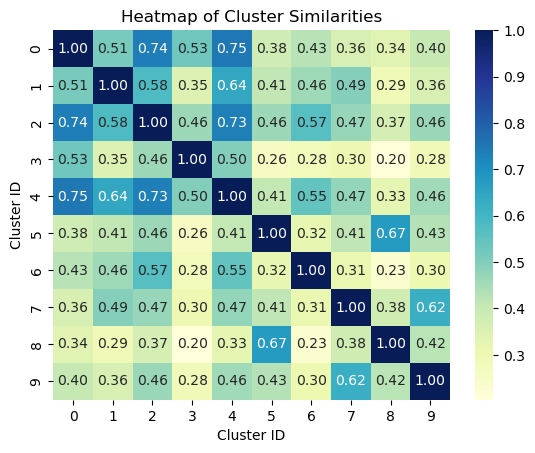

In [67]:
# 簇间相似度热力图
centroids = best_results['centroids']
similarity_matrix = np.zeros((best_k, best_k))

for i in range(best_k):
    for j in range(best_k):
        similarity_matrix[i, j] = np.dot(centroids[i], centroids[j]) / (np.linalg.norm(centroids[i]) * np.linalg.norm(centroids[j]))

sns.heatmap(similarity_matrix, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Heatmap of Cluster Similarities')
plt.xlabel('Cluster ID')
plt.ylabel('Cluster ID')

plt.show()

Starting clustering analysis for all datasets...

==================== Processing NIPS Papers ====================
Loading data...
Matrix shape: (1500, 12419)
Computing TF-IDF...
Performing dimensionality reduction...

Clustering with k=2...
算法在第 9 轮迭代后达到标签稳定
Silhouette Score: 0.0148

Clustering with k=5...
算法在第 15 轮迭代后达到标签稳定
Silhouette Score: 0.0134

Clustering with k=10...
算法在第 15 轮迭代后达到标签稳定
Silhouette Score: 0.0141

Clustering with k=20...
算法在第 9 轮迭代后达到标签稳定
Silhouette Score: 0.0152

==================== Processing KOS Blogs ====================
Loading data...
Matrix shape: (3430, 6906)
Computing TF-IDF...
Performing dimensionality reduction...

Clustering with k=2...
算法在第 9 轮迭代后达到标签稳定
Silhouette Score: 0.0191

Clustering with k=5...
算法在第 12 轮迭代后达到标签稳定
Silhouette Score: 0.0261

Clustering with k=10...
算法在第 20 轮迭代后达到标签稳定
Silhouette Score: 0.0259

Clustering with k=20...
算法在第 28 轮迭代后达到标签稳定
Silhouette Score: 0.0285

==================== Processing PUBMED ====================
Loading da

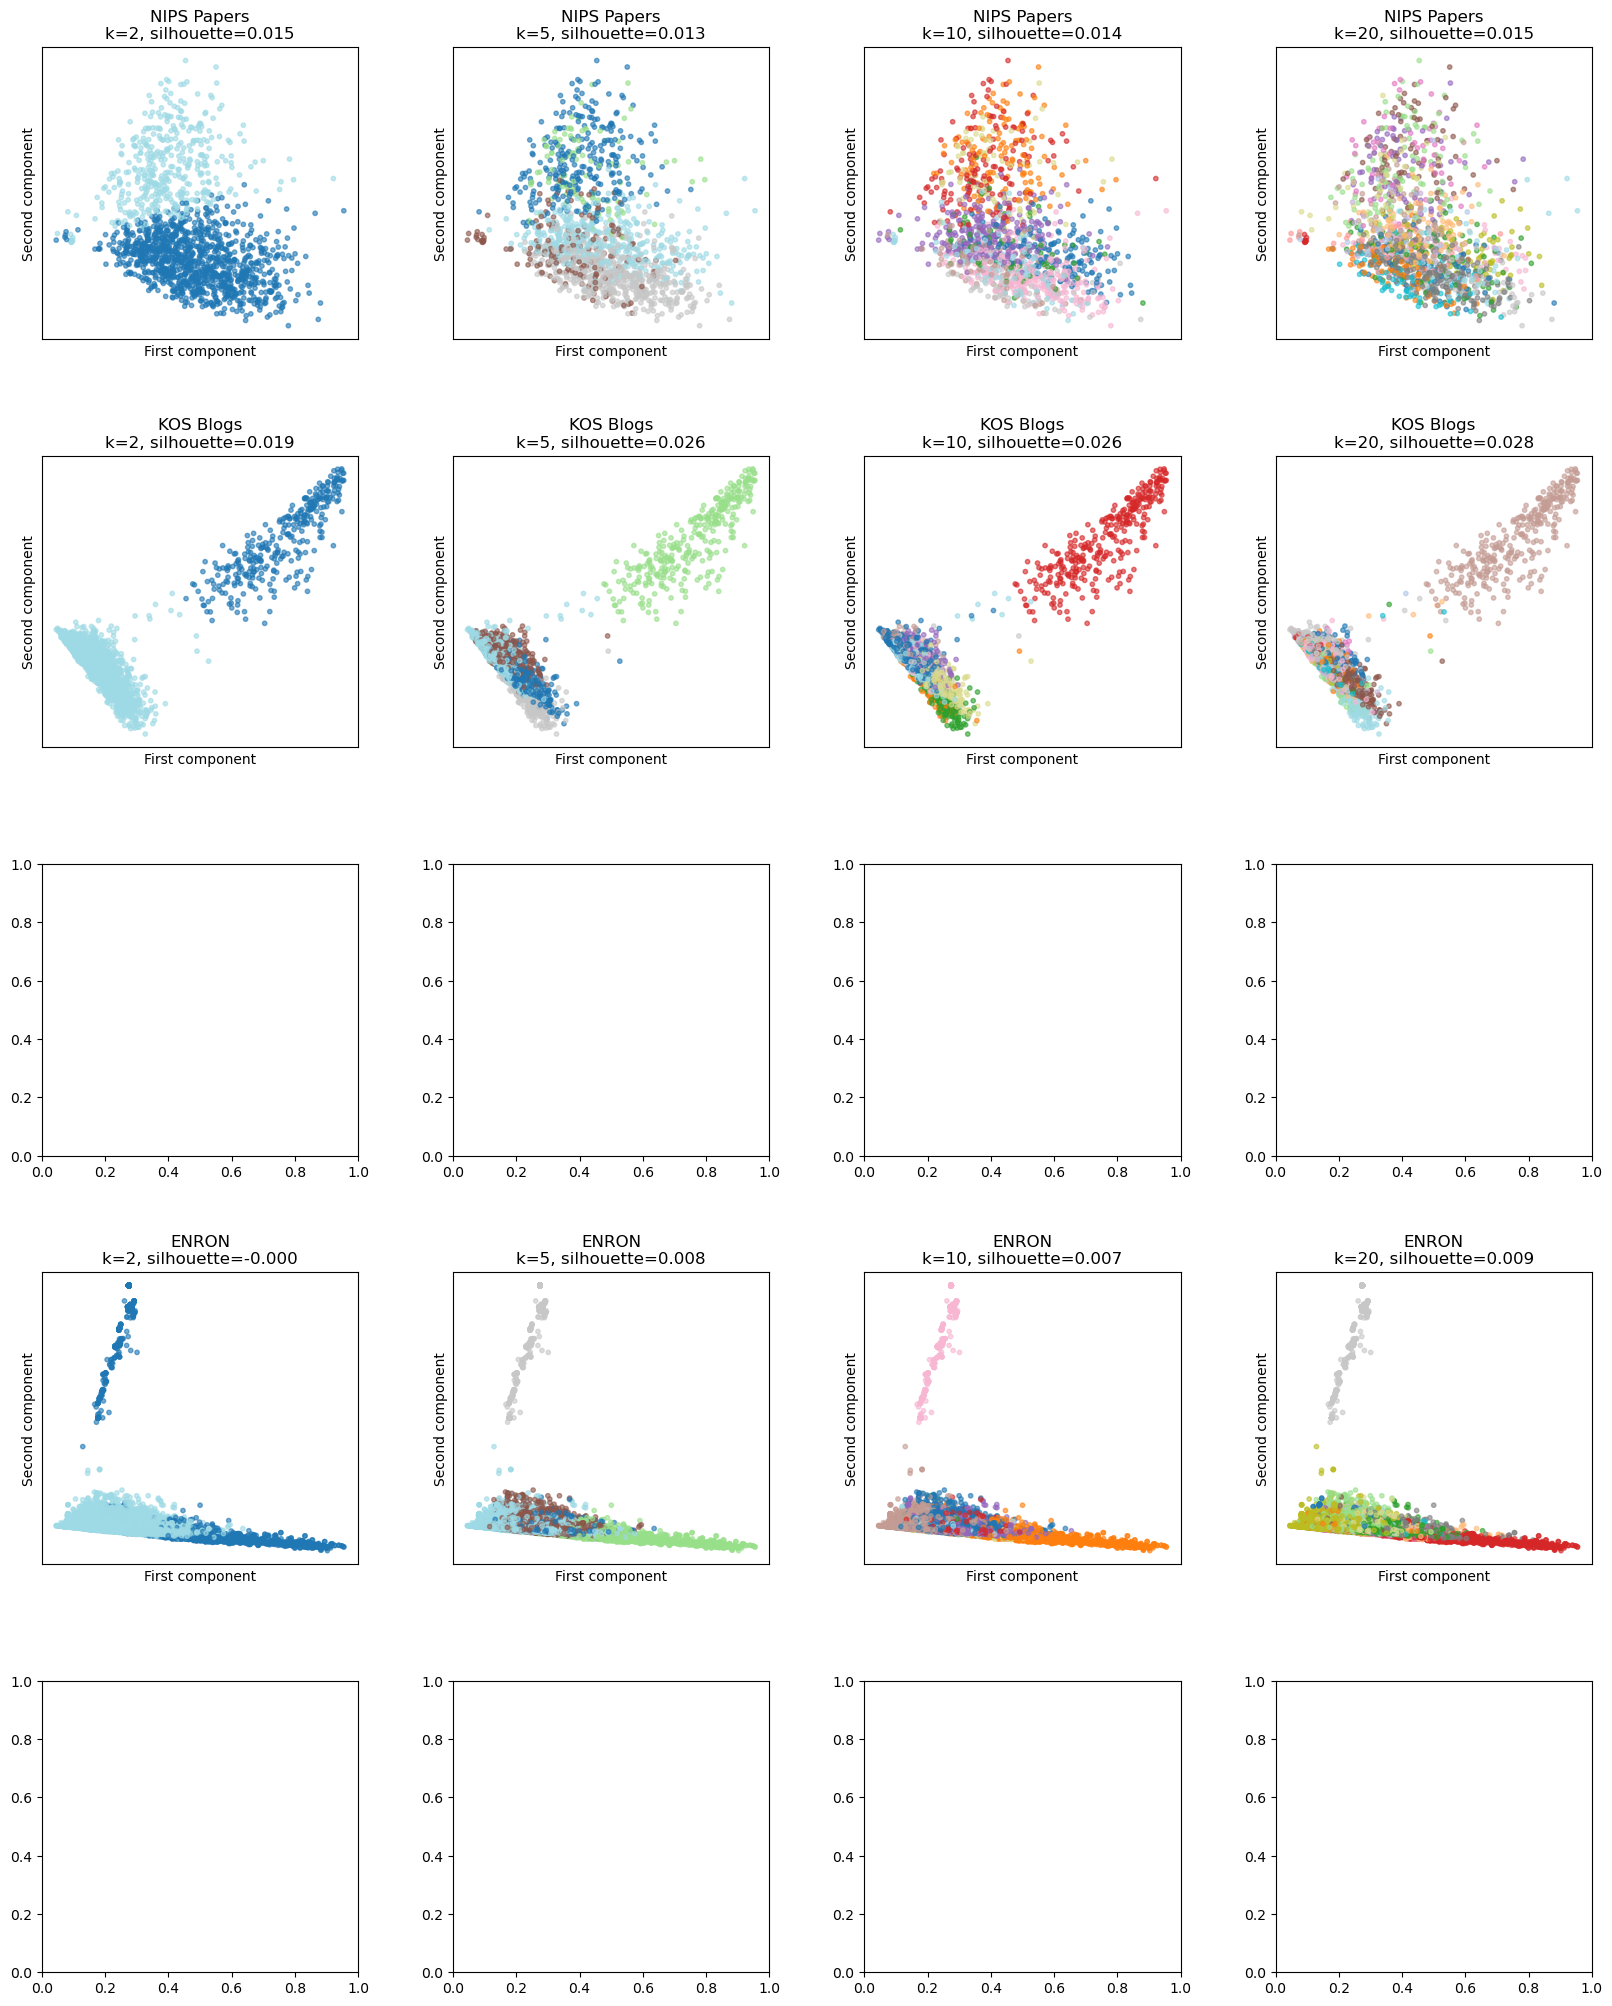

In [66]:
# 现在，我希望对于其他四个文本集也进行聚类，且进行散点图可视化
# Comprehensive Text Clustering Analysis for Multiple Datasets

import os
import numpy as np
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

def process_dataset(dataset, base_dir, k_values):
    """
    Process a single dataset through the complete clustering pipeline.
    
    Parameters:
        dataset: Dict containing dataset information
        base_dir: Base directory for data files
        k_values: List of k values to test
    """
    print(f"\n{'='*20} Processing {dataset['name']} {'='*20}")
    
    try:
        # Load data
        docword_file = os.path.join(base_dir, dataset["docword"])
        vocab_file = os.path.join(base_dir, dataset["vocab"])
        
        print("Loading data...")
        with open(docword_file, 'r') as f:
            lines = f.readlines()
        D, W, NNZ = map(int, lines[:3])
        data = np.array([list(map(int, line.strip().split())) for line in lines[3:]])
        
        # Create sparse matrix
        doc_ids = data[:, 0] - 1
        word_ids = data[:, 1] - 1
        counts = data[:, 2]
        sparse_matrix = sp.csr_matrix((counts, (doc_ids, word_ids)), shape=(D, W))
        
        print(f"Matrix shape: {sparse_matrix.shape}")
        
        # Compute TF-IDF
        print("Computing TF-IDF...")
        tfidf = TfidfTransformer().fit_transform(sparse_matrix)
        
        # Dimensionality reduction for visualization
        print("Performing dimensionality reduction...")
        svd = TruncatedSVD(n_components=2, random_state=42)
        coords_2d = svd.fit_transform(tfidf)
        
        # Perform clustering for each k
        results = {}
        for k in k_values:
            print(f"\nClustering with k={k}...")
            kmeans = MyKMeans(n_clusters=k, max_iter=100)
            kmeans.fit(tfidf)
            
            # Calculate silhouette score with sampling for large datasets
            if tfidf.shape[0] > 10000:
                sample_size = 10000
                indices = np.random.choice(tfidf.shape[0], sample_size, replace=False)
                silhouette_avg = silhouette_score(
                    tfidf[indices], kmeans.labels_[indices], sample_size=2000
                )
            else:
                silhouette_avg = silhouette_score(tfidf, kmeans.labels_)
            
            results[k] = {
                'labels': kmeans.labels_,
                'silhouette': silhouette_avg,
                'coords': coords_2d
            }
            
            print(f"Silhouette Score: {silhouette_avg:.4f}")
        
        return results
        
    except Exception as e:
        print(f"Error processing {dataset['name']}: {str(e)}")
        return None

def plot_clustering_results(all_results, datasets, k_values):
    """
    Create scatter plots for all datasets and k values.
    """
    n_datasets = len(datasets)
    n_k = len(k_values)
    
    fig, axes = plt.subplots(n_datasets, n_k, figsize=(5*n_k, 5*n_datasets))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    
    for i, dataset in enumerate(datasets):
        results = all_results[dataset['name']]
        if results is None:
            continue
            
        for j, k in enumerate(k_values):
            ax = axes[i][j]
            
            # Get clustering results
            labels = results[k]['labels']
            coords = results[k]['coords']
            silhouette = results[k]['silhouette']
            
            # Create scatter plot
            scatter = ax.scatter(coords[:, 0], coords[:, 1], 
                               c=labels, cmap='tab20', 
                               alpha=0.6, s=10)
            
            # Set title and labels
            ax.set_title(f"{dataset['name']}\nk={k}, silhouette={silhouette:.3f}")
            ax.set_xlabel("First component")
            ax.set_ylabel("Second component")
            
            # Remove ticks for cleaner visualization
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.show()

# Process all datasets
print("Starting clustering analysis for all datasets...")
all_results = {}

for dataset in config_para['datasets']:
    results = process_dataset(
        dataset, 
        config_para['base_dir'], 
        config_para['k_values']
    )
    all_results[dataset['name']] = results

# Create visualization
print("\nGenerating visualizations...")
plot_clustering_results(all_results, config_para['datasets'], config_para['k_values'])